## Imports


In [1]:
import argparse
import math
import random
import os
import time
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import pybullet as p
import pybullet_data
from env import DiffBotEnv, RobotParams

import matplotlib.pyplot as plt

pybullet build time: Nov  2 2025 19:45:45


## Test render env

In [2]:
#p.disconnect()

In [3]:
robot_params = RobotParams()

env = DiffBotEnv(gui=True, n_objects=15, seed=185, robot_params=robot_params)


Version = 4.1 Metal - 90.5
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
YCB URDFS: ['urdfs/ycb/ycb_assets/015_peach.urdf', 'urdfs/ycb/ycb_assets/071_nine_hole_peg_test.urdf', 'urdfs/ycb/ycb_assets/037_scissors.urdf', 'urdfs/ycb/ycb_assets/032_knife.urdf', 'urdfs/ycb/ycb_assets/058_golf_ball.urdf', 'urdfs/ycb/ycb_assets/029_plate.urdf', 'urdfs/ycb/ycb_assets/021_bleach_cleanser.urdf', 'urdfs/ycb/ycb_assets/010_potted_meat_can.urdf', 'urdfs/ycb/ycb_assets/072-a_toy_airplane.urdf', 'urdfs/ycb/ycb_assets/063-a_marbles.urdf', 'urdfs/ycb/ycb_assets/073-e_lego_duplo.urdf', 'urdfs/ycb/ycb_assets/065-c_cups.urdf', 'urdfs/ycb/ycb_assets/019_pitcher_base.urdf', 'urdfs/ycb/ycb_assets/008_pudding_box.urdf', 'urdfs/ycb/ycb_assets/072-d_toy_airplane.urdf', 'urdfs/ycb/ycb_assets/065-h_cups.urdf', 'urdfs/ycb/ycb_assets/059_chain.urdf', 'urdfs/ycb/ycb_assets/073-b_lego_duplo

# Policy

In [4]:
import torch
from PIL import Image
import clip

# Load CLIP model
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [5]:
def _to_pil(img_np):
    # img_np: HxWx3 uint8 from env.step(camera_feed=True) BVR
    # convert BGR to RGB
    img_np = img_np[:, :, ::-1]
    return Image.fromarray(img_np)

def _encode_text(prompt: str):
    with torch.no_grad():
        tokens = clip.tokenize([prompt]).to(device)
        txt = clip_model.encode_text(tokens)
        txt = txt / txt.norm(dim=-1, keepdim=True)
    return txt  # [1, d]

test_txt = _encode_text("a red ball")  # [1, d]
print(test_txt.shape) 

torch.Size([1, 512])


To choose the heading and speed we encode each sector of the image and take the one thats is the most similar to the text encoding

In [6]:
def _score_sectors(pil_img: Image.Image, text_emb: torch.Tensor, K=7):
    """
    Split the image into K vertical sectors, return CLIP cosine scores per sector.
    """
    W, H = pil_img.size
    w = W // K
    crops = []
    boxes = []
    for i in range(K):
        x0 = max(0, i*w - w//4)                 # small overlap
        x1 = min(W, x0 + w + w//2)
        crop = pil_img.crop((x0, 0, x1, H))
        crops.append(clip_preprocess(crop))
        boxes.append((x0, x1))
    imgs = torch.stack(crops).to(device)

    with torch.no_grad():
        img_feats = clip_model.encode_image(imgs)
        print(img_feats.shape)  #
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)  # [K, d]
        sims = (img_feats @ text_emb.T).squeeze(1)                    # [K]
    return sims, boxes

We then compute the angle needed to bring the most similar sector in the center of the image

In [7]:
def _sector_to_cmd(sims: torch.Tensor, K: int, fov_deg=120.0, v_max=10.00, w_gain=3.5, conf_th=0.12):
    """
    sims: [K] cosine scores. Pick argmax -> bearing in [-FOV/2, +FOV/2] (radians).
    Forward speed scales with confidence and reduces when turning sharply.
    """
    K = int(K)
    idx = int(torch.argmax(sims).item())
    fov = math.radians(fov_deg)
    # center angles for sectors
    bearings = np.linspace(-fov/2, fov/2, K)
    bearing = float(bearings[idx])
    conf = float(torch.softmax(sims, dim=0)[idx])
    # turn rate
    w = - w_gain * bearing

    # forward speed: zero if low confidence; otherwise slower when turning
    if conf < conf_th:
        v = 0.1
    else:
        v = v_max * conf * max(0.0, math.cos(bearing)) 
    return v, w, idx, conf

In [8]:
SMOOTH = 0.3
def compute_next_cmd(v, w, camera_feed, prompt):
    global text_emb, _prev_v, _prev_w
    if camera_feed is None:
        return 0.0, 0.0 # stop the robot if no camera feed

    text_emb = _encode_text(prompt)  # text is global for efficiency

    #converts the image and computes the sector scores
    pil = _to_pil(camera_feed)
    sims, _ = _score_sectors(pil, text_emb, K=7)
    #print(sims)  #

    # Convert chosen sector to bearing & forward speed
    v_cmd, w_cmd, idx, conf = _sector_to_cmd(sims, K=7, fov_deg=90.0)

    # Smooth commands 
    v_sm = SMOOTH * _prev_v + (1.0 - SMOOTH) * v_cmd
    w_sm = SMOOTH * _prev_w + (1.0 - SMOOTH) * w_cmd
    _prev_v, _prev_w = v_sm, w_sm
    return float(v_sm), float(w_sm), sims

In [9]:
from IPython.display import display
from PIL import Image

def plot_camera_feed(frame_bgr):
    rgb = frame_bgr[:, :, ::-1]
    pil = Image.fromarray(rgb)
    if not hasattr(plot_camera_feed, "h"):
        plot_camera_feed.h = display(pil, display_id=True)
    else:
        plot_camera_feed.h.update(pil)

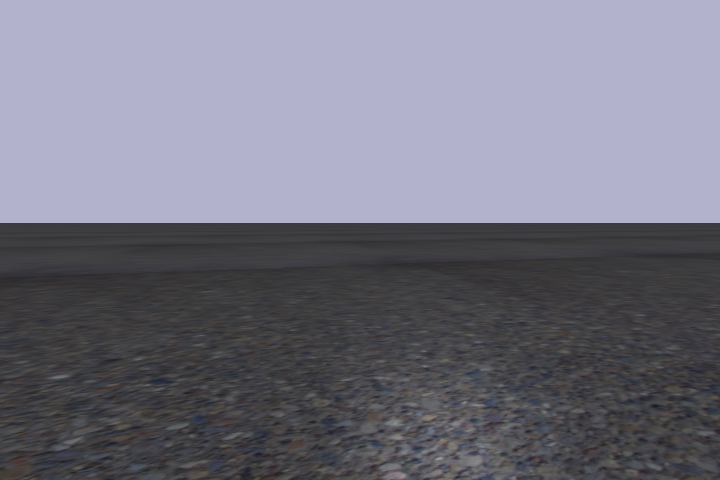

torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7, 512])
torch.Size([7

KeyboardInterrupt: 

In [10]:
v,w = 0.0, 0.0
_prev_v, _prev_w = 0.0, 0.0
prompt = "Go to the pink box on your right"

while True:
    camera_feed = env.step(steps=15, cmd=(v, w), camera_feed=True)
    # plot the camera feed
    plot_camera_feed(camera_feed)
    v,w, _ = compute_next_cmd(v, w, camera_feed, prompt)






In [ ]:
env.reset_pose()

In [ ]:
# quit the simulation without crashing the notebook and close the pybullet windo
p.disconnect()


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
